In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import openpyxl
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

#Show mols in dataframes
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from IPython.core.display import HTML
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import os

In [2]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
figures_dir = TOP + 'reports/figures/'


Reading in the Consensus PFAS Universe file

In [3]:
universe = pd.read_excel(interim_dir+'PFAS Universe 2021-08-25.xlsx')

In [4]:
universe.head()

,dtxsid,casrn,name,smiles,formula,nc,mw,vp,volatile,nickname,...,PFAS 54,PFAS NAM All,list_count,acute,subchronic,chronic,devtox,reprotox,neurotox,immunotox
0,DTXSID7029904,678-39-7,Fluorotelomer alcohol 8:2,OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...,C10H5F17O,10,464.122,2.070880e-01,F,8:2 FTOH,...,NaN,1.0,2,1,12,0,5,0,0,0
1,DTXSID3037707,29420-49-3,Potassium perfluorobutanesulfonate,[K+].[O-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,C4F9KO3S,4,338.180,1.136250e-08,F,KPFBS,...,NaN,1.0,2,4,10,3,3,5,0,0
2,DTXSID5044572,647-42-7,"3,3,4,4,5,5,6,6,7,7,8,8,8-Tridecafluorooctanol",OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,C8H5F13O,8,364.106,6.011380e-01,F,6:2 FTOH,...,NaN,1.0,2,3,10,1,4,9,0,0
3,DTXSID6047575,19430-93-4,"3,3,4,4,5,5,6,6,6-Nonafluorohexene",FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C=C,C6H3F9,6,246.076,2.135170e+03,T,"3,3,4,4,5,5,6,6,6-Nonafluorohexene",...,NaN,1.0,2,3,9,3,6,0,0,0
4,DTXSID0061826,1623-05-8,Perfluoropropyl trifluorovinyl ether,FC(F)=C(F)OC(F)(F)C(F)(F)C(F)(F)F,C5F10O,5,266.038,2.130420e+02,T,PPVE,...,1.0,1.0,3,5,8,2,4,0,0,0


In [5]:
universe['vp'].isnull().sum()

54

In [6]:
universe = universe[universe['vp'].notnull()]

In [7]:
def subcategory(row):
    if row['volatile'] == 'T':
        return 'volatile'
    elif row['nc'] >= 8:
        return 'gte8'
    else:
        return 'lt8'

In [8]:
universe['subcategory'] = universe.apply(lambda row: subcategory(row), axis =1)

In [9]:
universe.groupby(['category', 'subcategory']).size().sort_values(ascending = False)

category                       subcategory
Others                         gte8           1927
                               volatile        775
                               lt8             656
PFAA precursors                gte8            597
unclassified                   gte8            503
Fluorotelomer PFAA precursors  gte8            343
PFAA precursors                lt8             253
PFAAs                          gte8            222
Others, cyclic                 gte8            213
PFAAs                          lt8             129
Non-PFAA perfluoroalkyls       volatile        125
Others, cyclic                 volatile        118
FASA based PFAA precursors     gte8            114
PFAA precursors                volatile        111
Others, cyclic                 lt8              86
Fluorotelomer PFAA precursors  volatile         57
Non-PFAA perfluoroalkyls       gte8             55
unclassified                   lt8              51
Fluorotelomer PFAA precursors  lt8     

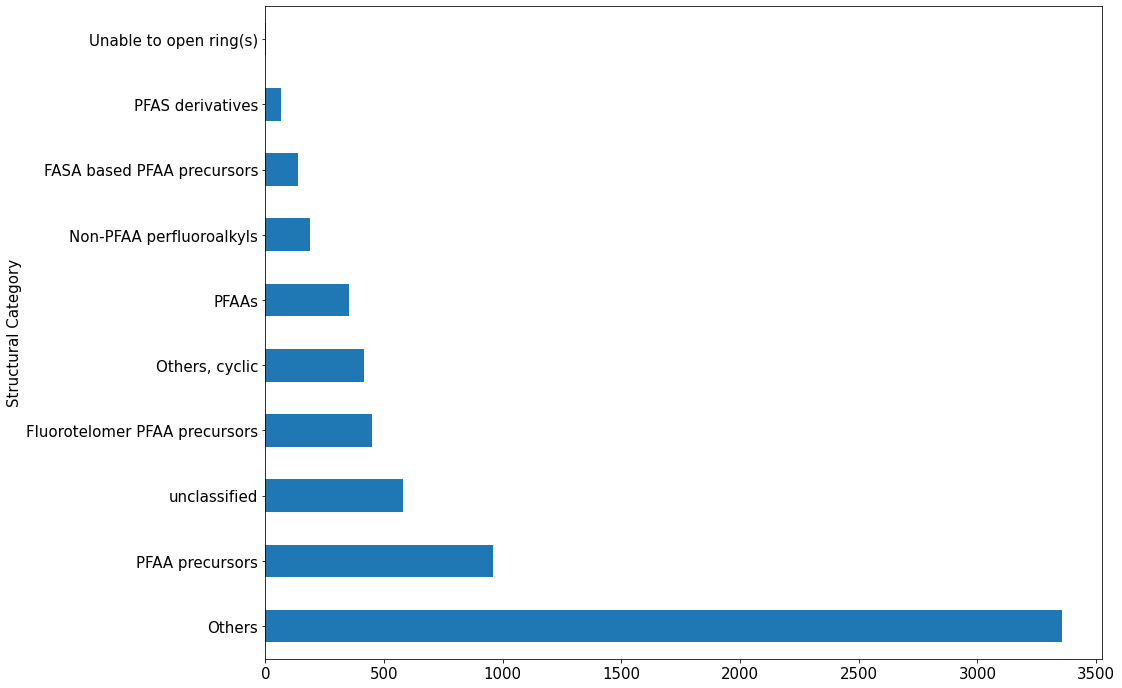

In [11]:
universe.category.value_counts().plot.barh(figsize = (15,12), fontsize = 15, legend = False)
plt.ylabel('Structural Category' ,fontsize = 15)
plt.savefig(figures_dir+'frequency_categories_pfas_universe_161121.png', dpi = 300, bbox_inches='tight');

In [53]:
list_index_order = universe.category.value_counts().reset_index()['index'].tolist()[::-1]

In [15]:
#universe.to_csv(interim_dir+'pfas6504_4TxPs_161121.csv')

In [10]:
def txp_categories(text_file):
    df = pd.read_csv(text_file, sep = ';')
    df.rename(columns = {'M_NAME': 'DTXSID'},inplace = True)
    df = df.set_index('DTXSID')
    df.drop(['M_COMPOUND_HISTORY_[STRING]','M_CORINA_SYMPHONY_ERRORS_[STRING]'],axis = 1, inplace = True)
    test_rev = []
    for i, row in df.iterrows():
        if (row['bond:C=O_carbonyl_generic'] == 1 ) & (row['bond:CC(=O)C_ketone_aliphatic_generic'] == 1):
            test_rev.append([i,'TxP_PFAS_ketone'])
        if (row['bond:C(=O)O_carboxylicEster_alkenyl'] == 1) & (row['bond:C(=O)O_carboxylicEster_acyclic'] == 1) &  (row['chain:alkeneLinear_mono-ene_ethylene_generic'] ==1) & (row['bond:C=O_carbonyl_generic'] ==1 ):
            test_rev.append([i,'TxP_PFAS_acrylate'])
        if (row['bond:COH_alcohol_aliphatic_generic'] == 1) & (row['bond:COH_alcohol_generic'] ==1):
            test_rev.append([i, 'TxP_PFAS_alcohol'])
        if (row['bond:COH_alcohol_aliphatic_generic'] == 1) & (row['bond:COH_alcohol_generic'] ==1) & (row['bond:COH_alcohol_pri-alkyl'] == 1):
            test_rev.append([i,'TxP_PFAS_alcohol_primary']) 
        if (row['bond:COH_alcohol_aliphatic_generic'] == 1) & (row['bond:COH_alcohol_generic'] ==1) & (row['bond:COH_alcohol_pri-alkyl'] == 1) & (row['bond:COH_alcohol_sec-alkyl'] ==1):
            test_rev.append([i,'TxP_PFAS_alcohol_primary_FT_diol']) 
        if (row['bond:COH_alcohol_aliphatic_generic'] == 1) & (row['bond:COH_alcohol_generic'] ==1) & (row['bond:COH_alcohol_pri-alkyl'] == 1) & (row['bond:C(~Z)~C~Q_a-haloalcohol'] ==1):
            test_rev.append([i,'TxP_PFAS_alcohol_primary_FTn1']) 
        if (row['bond:COH_alcohol_aliphatic_generic'] == 1) & (row['bond:COH_alcohol_generic'] ==1) & (row['bond:COH_alcohol_pri-alkyl'] == 1) & (row['chain:alkaneLinear_propyl_C3'] ==1) & (row['chain:alkaneLinear_ethyl_C2(H_gt_1)'] == 1):
            test_rev.append([i,'TxP_PFAS_alcohol_primary_FTn2'])
        if (row['bond:COH_alcohol_aliphatic_generic'] == 1) & (row['bond:COH_alcohol_generic'] ==1) & (row['bond:C(~Z)~C~Q_a-haloalcohol'] == 1) & (row['bond:COH_alcohol_pri-alkyl'] == 0):
            test_rev.append([i,'TxP_PFAS_alcohol_polyF']) 
        if (row['bond:COH_alcohol_aliphatic_generic'] == 1) & (row['bond:COH_alcohol_generic'] ==1) & (row['bond:S(=O)N_sulfonylamide'] ==1):
            test_rev.append([i,'TxP_PFAS_alcohol_sulfonylamide']) 
        if (row['bond:CN_amine_aliphatic_generic'] ==1):
            test_rev.append([i,'TxP_PFAS_amine']) 
        if (row['bond:CN_amine_aliphatic_generic'] ==1) & (row['bond:COC_ether_aliphatic'] ==1):
            test_rev.append([i,'TxP_PFAS_amine_ether']) 
        if (row['bond:CN_amine_aliphatic_generic'] ==1) & (row['bond:CN_amine_pri-NH2_alkyl'] ==1):
            test_rev.append([i,'TxP_PFAS_amine_primary']) 
        if (row['bond:C(=O)O_carboxylicAcid_generic'] ==1):
            test_rev.append([i,'TxP_PFAS_COOH']) 
        if (row['bond:C(=O)O_carboxylicAcid_generic'] ==1) & (row['bond:COC_ether_aliphatic'] ==1):
            test_rev.append([i,'TxP_PFAS_COOH_ether']) 
        if (row['bond:C(=O)O_carboxylicAcid_generic'] ==1) & (row['chain:alkeneLinear_mono-ene_ethylene_generic'] ==1):
            test_rev.append([i,'TxP_PFAS_COOH_ethylene']) 
        if (row['bond:C(=O)O_carboxylicAcid_generic'] ==1) & (row['bond:C(=O)O_carboxylicAcid_alkyl'] ==1) & (row['chain:alkaneLinear_ethyl_C2(H_gt_1)'] ==1) & (row['chain:alkaneLinear_propyl_C3'] ==1) & (row['chain:alkaneLinear_ethyl_C2_(connect_noZ_CN=4)'] ==1):
            test_rev.append([i,'TxP_PFAS_COOH_FT'])
        if (row['bond:C(=O)O_carboxylicEster_acyclic'] ==1) & (row['bond:C(=O)O_carboxylicEster_alkyl'] ==1) & (row['bond:C=O_carbonyl_generic'] ==1):
            test_rev.append([i,'TxP_PFAS_COOR']) 

        if (row['bond:S=O_sulfonyl_generic'] ==1):
            test_rev.append([i,'TxP_PFAS_sulfonyl']) 
        if (row['bond:S=O_sulfonyl_generic'] ==1) & (row['bond:S(=O)N_sulfonylamide'] == 1):   
            test_rev.append([i,'TxP_PFAS_sulfonamide'])
        if (row['bond:S=O_sulfonyl_generic'] == 1) & (row['bond:S(=O)N_sulfonylamide'] == 1) & (row['bond:COH_alcohol_generic'] ==1):
            test_rev.append([i,'TxP_PFAS_sulfonamide_alcohol'])
        if (row['bond:S(=O)O_sulfonicAcid_generic'] == 1) & (row['bond:S(=O)O_sulfonate'] == 1) & (row['bond:S(=O)O_sulfonicAcid_acyclic_(chain)'] == 1):
            test_rev.append([i,'TxP_PFAS_sulfonate']) 
        if (row['bond:S(=O)O_sulfonicAcid_generic'] == 1) & (row['bond:S(=O)O_sulfonate'] == 1) & (row['bond:S(=O)O_sulfonicAcid_acyclic_(chain)'] == 1) & (row['chain:alkaneLinear_ethyl_C2(H_gt_1)'] == 1) & (row['chain:alkaneLinear_propyl_C3'] == 1):   
            test_rev.append([i,'TxP_PFAS_sulfonate_FTn2'])
        if (row['bond:S=O_sulfonyl_generic'] ==1) & (row['bond:S(=O)X_sulfonylhalide'] ==1):
            test_rev.append([i,'TxP_PFAS_sulfonylhalide']) 
        if (row['bond:COC_ether_aliphatic'] ==1):
            test_rev.append([i,'TxP_PFAS_ether']) 
        if (row['bond:metal_metalloid_Si_organo'] ==1):
            test_rev.append([i,'TxP_PFAS_silane'])
        if (row['bond:C(=O)N_carboxamide_generic'] ==1):
            test_rev.append([i,'TxP_PFAS_carboxamide'])
        if (row['bond:C=O_acyl_halide'] ==1):
            test_rev.append([i,'TxP_PFAS_acylhalide'])
        if (row['bond:OZ_oxide_hyroxy'] ==1):
            test_rev.append([i,'TxP_PFAS_oxidehydroxy'])
        if (row['bond:CX_halide_alkyl-F_perfluoro_hexyl'] == 1) & (row['bond:CX_halide_alkyl-F_perfluoro_octyl'] == 0):
            test_rev.append([i,'TxP_PFAS_perFhexyl'])
        if (row['bond:CX_halide_alkyl-F_perfluoro_octyl'] == 1):
            test_rev.append([i,'TxP_PFAS_perFoctyl']) 
        if (row['bond:CX_halide_alkyl-X_primary'] == 1):
            test_rev.append([i,'TxP_PFAS_alkylXprimary'])
        if (row['bond:CX_halide_alkyl-X_tertiary'] == 1) & (row['bond:C=O_carbonyl_generic'] == 0): 
            test_rev.append([i, 'TxP_PFAS_alkylXtertiaryxCO']) 
        if (row['chain:alkeneLinear_mono-ene_ethylene_generic'] == 1) & (row['bond:C=O_carbonyl_generic'] == 0): 
            test_rev.append([i, 'TxP_PFAS_ethylene_xCO'])
        if (row['bond:C=O_carbonyl_generic'] == 1) & (row['bond:C(=O)N_carboxamide_generic'] == 0) & (row['bond:C(=O)O_carboxylicAcid_generic'] == 0) & (row['bond:C(=O)O_carboxylicEster_alkenyl'] == 0) & (row['bond:C(=O)O_carboxylicEster_alkyl'] == 0) & (row['bond:C=O_acyl_halide'] == 0) & (row['bond:CC(=O)C_ketone_aliphatic_generic'] == 0): 
            test_rev.append([i,'TxP_PFAS_aldehydeanhydride'])
    return pd.DataFrame(test_rev, columns = ['DTXSID', 'Txp_cats'])       

In [11]:
universe_txps = txp_categories(interim_dir+'OPSCPP_4TxPs_res.txt')

In [12]:
#from sklearn.preprocessing import OneHotEncoder

In [13]:
#enc = OneHotEncoder(handle_unknown='ignore')

In [14]:
universe_txps.set_index('DTXSID', inplace = True)

In [15]:
onehot = pd.get_dummies(universe_txps["Txp_cats"])

In [16]:
universe_txps_2 = pd.merge(universe_txps, onehot, on = universe_txps.index, how = 'left')

In [17]:
universe_txps_3 = universe_txps_2.groupby('key_0').max().reset_index()

In [18]:
universe_txps_3.drop(['Txp_cats'], axis = 1, inplace = True)

In [19]:
universe_txps_3.rename(columns = {'key_0': 'DTXSID'}, inplace = True)

In [20]:
universe_txps_3.rename(columns = {'DTXSID': 'dtxsid'}, inplace = True)

In [21]:

df2 = pd.merge(universe, universe_txps_3, on = 'dtxsid', how = 'left')

In [22]:
df2.columns.get_loc('TxP_PFAS_COOH')

27

In [23]:
df2.columns[27:]

Index(['TxP_PFAS_COOH', 'TxP_PFAS_COOH_FT', 'TxP_PFAS_COOH_ether',
       'TxP_PFAS_COOH_ethylene', 'TxP_PFAS_COOR', 'TxP_PFAS_acrylate',
       'TxP_PFAS_acylhalide', 'TxP_PFAS_alcohol', 'TxP_PFAS_alcohol_polyF',
       'TxP_PFAS_alcohol_primary', 'TxP_PFAS_alcohol_primary_FT_diol',
       'TxP_PFAS_alcohol_primary_FTn1', 'TxP_PFAS_alcohol_primary_FTn2',
       'TxP_PFAS_alcohol_sulfonylamide', 'TxP_PFAS_aldehydeanhydride',
       'TxP_PFAS_alkylXprimary', 'TxP_PFAS_alkylXtertiaryxCO',
       'TxP_PFAS_amine', 'TxP_PFAS_amine_ether', 'TxP_PFAS_amine_primary',
       'TxP_PFAS_carboxamide', 'TxP_PFAS_ether', 'TxP_PFAS_ethylene_xCO',
       'TxP_PFAS_ketone', 'TxP_PFAS_oxidehydroxy', 'TxP_PFAS_perFhexyl',
       'TxP_PFAS_perFoctyl', 'TxP_PFAS_silane', 'TxP_PFAS_sulfonamide',
       'TxP_PFAS_sulfonamide_alcohol', 'TxP_PFAS_sulfonate',
       'TxP_PFAS_sulfonate_FTn2', 'TxP_PFAS_sulfonyl',
       'TxP_PFAS_sulfonylhalide'],
      dtype='object')

In [33]:
hm_data = df2.groupby('category')[df2.columns[27:]].agg('sum').astype(int)

In [55]:
list_index_order

['Unable to open ring(s)',
 'PFAS derivatives',
 'FASA based PFAA precursors',
 'Non-PFAA perfluoroalkyls',
 'PFAAs',
 'Others, cyclic',
 'Fluorotelomer PFAA precursors',
 'unclassified',
 'PFAA precursors',
 'Others']

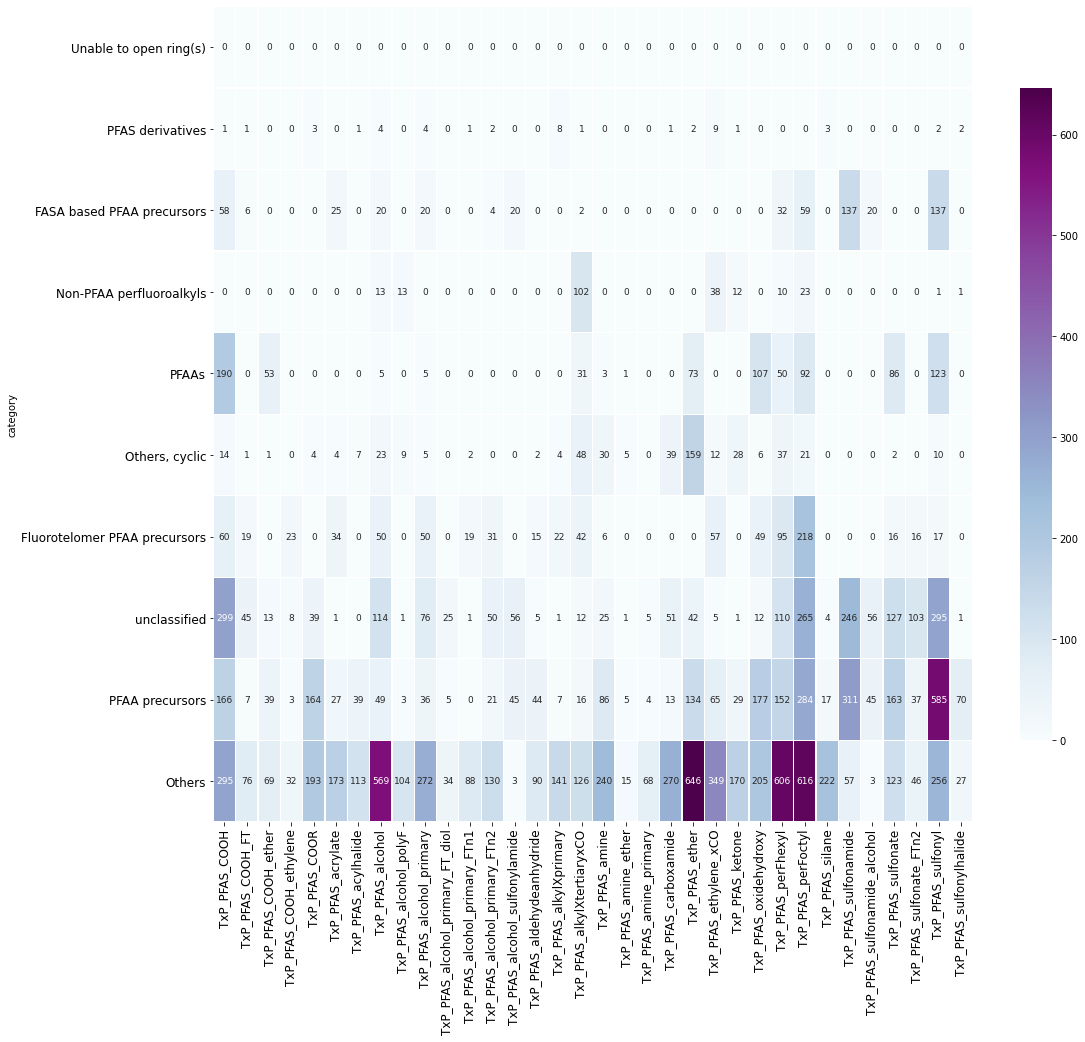

In [66]:
plt.figure(figsize = (17,15))
sns.heatmap(hm_data.reindex(list_index_order), annot = True, fmt = 'd',cmap = 'BuPu',linewidth=0.3,  annot_kws={"size": 9}, cbar_kws={"shrink": .8})
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12);
plt.savefig(figures_dir+'oecd_vs_TxP_cats_PFASEPA_140422.png', dpi = 300, bbox_inches='tight');

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 [Text(0, 0.5, 'FASA based PFAA precursors'),
  Text(0, 1.5, 'Fluorotelomer PFAA precursors'),
  Text(0, 2.5, 'Non-PFAA perfluoroalkyls'),
  Text(0, 3.5, 'Others'),
  Text(0, 4.5, 'Others, cyclic'),
  Text(0, 5.5, 'PFAA precursors'),
  Text(0, 6.5, 'PFAAs'),
  Text(0, 7.5, 'PFAS derivatives'),
  Text(0, 8.5, 'Unable to open ring(s)'),
  Text(0, 9.5, 'unclassified')])

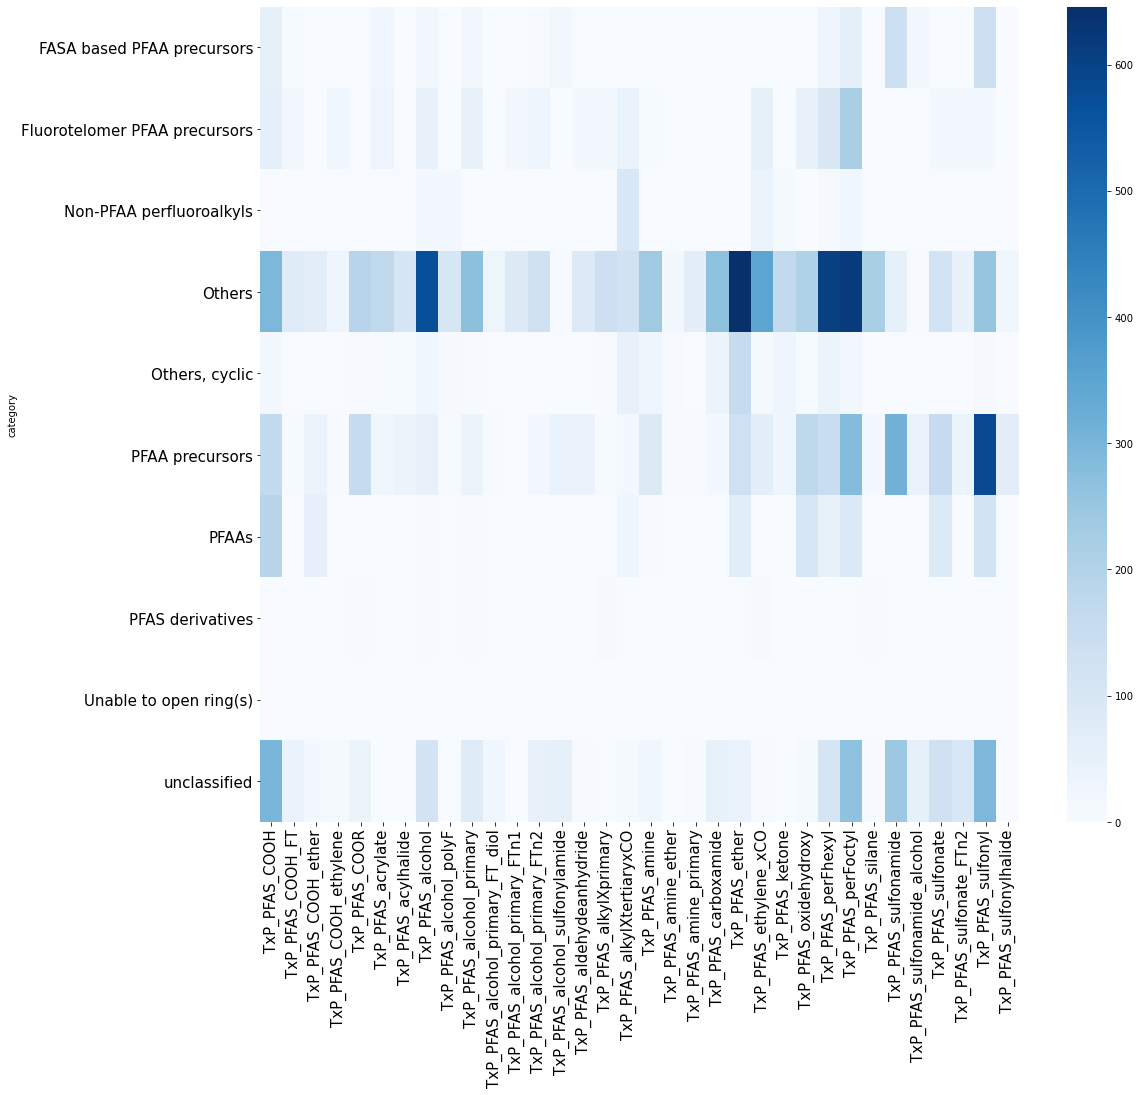

In [67]:
plt.figure(figsize = (17,15))
sns.heatmap(df2.groupby('category')[df2.columns[27:]].agg('sum').astype(int), annot = False, fmt = 'd',cmap = 'Blues', annot_kws={"size": 12})
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
#plt.savefig(figures_dir+'oecd_vs_TxP_cats_PFASEPA_161121.png', dpi = 300, bbox_inches='tight');

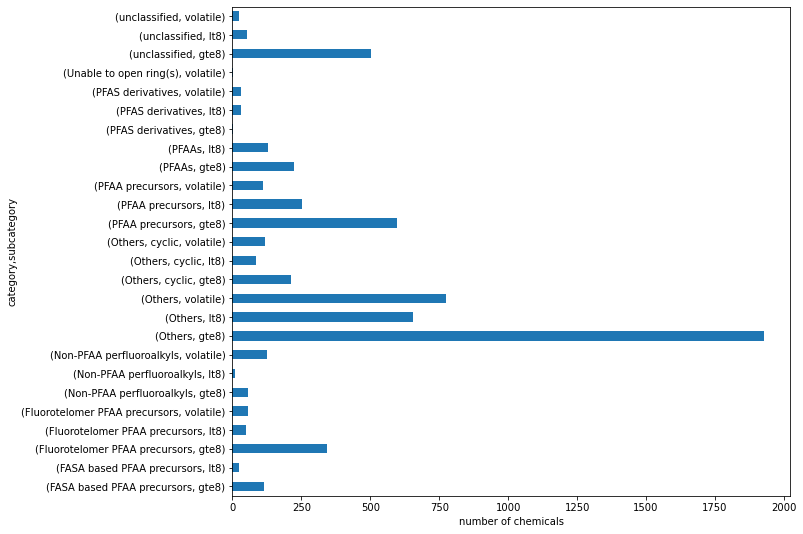

In [69]:
plt.figure(figsize = (10,9))
universe.groupby(['category', 'subcategory']).size().plot.barh()
plt.xlabel('number of chemicals')
plt.savefig(figures_dir+'frequency_categories_pfasepa_161121.png', dpi = 300, bbox_inches='tight');

In [451]:
import sqlalchemy as sa

In [452]:
username = 'grace'
password = 'graceSQL'
host = 'localhost'

In [453]:
engine = sa.create_engine(f"""mysql+pymysql://{username}:{password}@{host}""")

In [454]:
insp = sa.inspect(engine)
db_list = insp.get_schema_names()
db_list

['cinema_booking_system',
 'dol_production',
 'dol_test_new',
 'grace_problem',
 'information_schema',
 'mysql',
 'oflc_test',
 'performance_schema',
 'pfas_db_20210707',
 'pfas_db_20211011',
 'sys',
 'test',
 'toxrefdb_2_0',
 'toxrefdb_2_0_all',
 'toxval9',
 'toxval_9_1']

In [455]:
pfas_db = sa.create_engine(f"""mysql+pymysql://{username}:{password}@{host}/pfas_db_20211011""")

In [456]:
pfas_db.table_names()

['Categories',
 'ChemList',
 'HTPP_Cats',
 'HTPP_Chem',
 'HTPP_Cytotox',
 'HTPP_feature',
 'HTS',
 'HTTR_signature',
 'HTTR_signature_active',
 'HTTR_supertarget',
 'PFAS_Landscape',
 'QC',
 'QC_summary',
 'biodeg6558',
 'invivo',
 'physchem']

In [457]:
pd.read_sql('''select * from Categories limit 10''', pfas_db)

,index,dtxsid,casrn,name,value
0,0,DTXSID70321097,84649-61-6,"2-(2-amino-5-tert-butylphenyl)-1,1,1,3,3,3-hex...",Others
1,1,DTXSID30321098,84649-62-7,"6-tert-butyl-2,2-dimethyl-4,4-bis(trifluoromet...",Others
2,2,DTXSID90321099,84649-63-8,"2-[6-tert-butyl-2,2-dimethyl-4,4-bis(trifluoro...",Others
3,3,DTXSID80327626,256333-13-8,"Ethyl [1,1,1,3,3,3-hexafluoro-2-(2-pyrimidinyl...",Others
4,4,DTXSID40327627,5226-19-7,"2-Ethoxy-6-morpholino-4,4-di(trifluoromethyl)-...","Others, cyclic"
5,5,DTXSID10327679,564-10-3,2H-Perfluoroisobutyric acid,Others
6,6,DTXSID10344962,126681-21-8,"(1E)-4,4,5,5,6,6,6-Heptafluoro-1-iodo-3,3-bis(...",Others
7,7,DTXSID50346182,41125-49-9,"[2,2,2-Trifluoro-1,1-bis(trifluoromethyl)ethyl...",Others
8,8,DTXSID80347107,352317-57-8,"3,4-Dihydro-6-phenyl-4,4-bis(trifluoromethyl)-...",Others
9,9,DTXSID50347174,26029-51-6,"1-Fluoro-4-[2,2,2-trifluoro-1,1-bis(trifluorom...",Others


In [458]:
pd.read_sql('''select distinct(value) from ChemList''',pfas_db)

,value
0,PFAS Master
1,PFAS Struct4
2,PFAS_6558
3,PFAS in vitro
4,PFAS 430
5,PFAS 54
6,PFAS 3M
7,PFAS 75-1
8,PFAS 75-2
9,PFAS round 2


In [64]:
pd.read_sql('''select count(*) from invivo''',pfas_db)

,count(*)
0,16973


In [70]:
pd.read_sql('''select count(distinct(dtxsid)) from invivo where human_eco = 'human health' and toxval_type_supercategory = 'Point of Departure' ''',pfas_db)

,count(distinct(dtxsid))
0,133


In [95]:
pd.read_sql('''select distinct(risk_assessment_class) from invivo where human_eco = 'human health' ''',pfas_db)

,risk_assessment_class
0,acute
1,-
2,mortality:acute
3,morphology:acute
4,development:chronic
5,growth:acute
6,development:acute
7,morphology:chronic
8,growth:chronic


In [96]:
engine = sa.create_engine(f"""mysql+pymysql://{username}:{password}@{host}""")
engine.execute("CREATE DATABASE toxval_9_1")

In [97]:
engine.execute("USE toxval_9_1")

In [98]:
toxval_db = sa.create_engine(f"""mysql+pymysql://{username}:{password}@{host}/toxval_9_1""")

In [99]:
chunk_size=50000
batch_no=1
for chunk in pd.read_csv(external_dir+'toxval_all_with_references_dev_toxval_v9_1_2021-06-01.csv', chunksize=chunk_size,iterator=True):
    chunk.to_sql('toxval_9_1',toxval_db, if_exists='append')
    batch_no+=1
    print('index: {}'.format(batch_no))

/home/grace/anaconda3/envs/pfas_dap/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (23,47,61) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


index: 2
index: 3
index: 4
index: 5


/home/grace/anaconda3/envs/pfas_dap/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (47,61) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


index: 6
index: 7
index: 8
index: 9
index: 10
index: 11
index: 12


/home/grace/anaconda3/envs/pfas_dap/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


index: 13
index: 14
index: 15
index: 16
index: 17
index: 18
index: 19
index: 20


In [226]:
pd.read_sql('''select count(distinct(source)) from toxval_9_1 ''', toxval_db)

,count(distinct(source))
0,43


In [103]:
pfas_db = sa.create_engine(f"""mysql+pymysql://{username}:{password}@{host}/pfas_db_20211011""")

In [142]:
pfas_iv = pd.read_sql('''select * from toxval_9_1.toxval_9_1 where  dtxsid in (select distinct(dtxsid) from ChemList)   ''', pfas_db)

In [143]:
pfas_iv.shape

(39510, 68)

In [227]:
pfas_iv.source.nunique()

33

In [145]:
#pfas_iv.risk_assessment_class.value_counts()

In [148]:
categories = pd.read_sql('''select * from Categories''', pfas_db)

In [152]:
pfas_iv_wcats = pd.merge(pfas_iv, categories[['dtxsid','value']], on = 'dtxsid', how = 'left')

In [154]:
pfas_iv_wcats
pfas_iv_wcats['value'] =pfas_iv_wcats['value'].replace(np.nan, 'unclassified')

In [233]:
pfas_iv_wcats.columns

Index(['index', 'dtxsid', 'casrn', 'name', 'toxval_id', 'source', 'subsource',
       'toxval_type', 'toxval_type_original', 'toxval_subtype',
       'toxval_subtype_original', 'toxval_type_category',
       'toxval_type_supercategory', 'toxval_numeric_qualifier',
       'toxval_numeric', 'toxval_numeric_original', 'toxval_units',
       'toxval_units_original', 'risk_assessment_class', 'study_type',
       'study_type_original', 'study_duration_class',
       'study_duration_class_original', 'study_duration_value',
       'study_duration_value_original', 'study_duration_units',
       'study_duration_units_original', 'species_original', 'species_common',
       'species_supercategory', 'habitat', 'human_eco', 'strain',
       'strain_original', 'sex', 'sex_original', 'generation', 'lifestage',
       'exposure_route', 'exposure_route_original', 'exposure_method',
       'exposure_method_original', 'exposure_form', 'exposure_form_original',
       'media', 'media_original', 'critical_e

In [238]:
pfas_iv_wcats_ = pfas_iv_wcats[pfas_iv_wcats['toxval_type_category'].isin(['NOEL', 'NEL', 'LEL', 'NOEC', 'NOAEL', 'NOAEC', 'LOAEL', 'LOEL', 'LOAEC'])]

In [239]:
pfas_iv_wcats_.dtxsid.nunique()

139

In [155]:
iv_df = pfas_iv_wcats.groupby(['value', 'risk_assessment_class']).agg({'dtxsid': ['count', 'nunique']}).reset_index()

In [156]:
iv_df

value       risk_assessment_class dtxsid        
                                                             count nunique
0    FASA based PFAA precursors                       acute     26       5
1    FASA based PFAA precursors           acute development      1       1
2    FASA based PFAA precursors                acute growth      2       2
3    FASA based PFAA precursors             acute mortality    182       1
4    FASA based PFAA precursors                     chronic      6       3
..                          ...                         ...    ...     ...
153                unclassified                reproduction     12       3
154                unclassified  reproduction developmental      1       1
155                unclassified                  short-term      2       2
156                unclassified                    subacute      1       1
157                unclassified                  subchronic     12       3

[158 rows x 4 columns]

In [157]:
iv_df = iv_df.droplevel(0, axis =1)

In [159]:
iv_df.columns = ['OECD Categories', 'risk_assessment_class', 'count', 'nunique']

In [160]:
ivdf_pvt = iv_df.pivot_table(columns = 'risk_assessment_class', values = 'nunique', index = 'OECD Categories')

In [161]:
ivdf_pvt

risk_assessment_class,acute,acute development,acute growth,acute morphology,acute mortality,acute reproduction,air quality standard,carcinogenicity,chronic,chronic development,...,neurotoxicity,other,physchem,repeat dose,"repeat dose, carcinogenicity",reproduction,reproduction developmental,short-term,subacute,subchronic
OECD Categories,,,,,,,,,,,,,,,,,,,,,
FASA based PFAA precursors,5.0,1.0,2.0,NaN,1.0,NaN,NaN,NaN,3.0,1.0,...,NaN,NaN,NaN,2.0,NaN,2.0,1.0,3.0,NaN,4.0
Fluorotelomer PFAA precursors,11.0,7.0,12.0,9.0,20.0,3.0,NaN,NaN,7.0,3.0,...,NaN,NaN,NaN,4.0,NaN,3.0,3.0,7.0,3.0,7.0
Non-PFAA perfluoroalkyls,18.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,4.0,1.0,...,1.0,NaN,NaN,4.0,NaN,2.0,NaN,2.0,1.0,3.0
Not PFAS,2.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Others,73.0,7.0,8.0,2.0,11.0,7.0,NaN,1.0,20.0,5.0,...,1.0,3.0,1.0,8.0,1.0,14.0,10.0,20.0,2.0,13.0
"Others, cyclic",9.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,6.0,NaN,...,1.0,NaN,NaN,2.0,NaN,2.0,1.0,1.0,NaN,3.0
PFAA precursors,20.0,2.0,3.0,3.0,10.0,2.0,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,2.0,NaN,2.0,1.0,2.0,NaN,NaN
PFAAs,20.0,22.0,27.0,22.0,36.0,15.0,NaN,1.0,12.0,10.0,...,1.0,2.0,3.0,2.0,1.0,12.0,3.0,9.0,2.0,16.0
PFAS derivatives,5.0,2.0,NaN,NaN,2.0,NaN,2.0,1.0,2.0,NaN,...,NaN,NaN,1.0,2.0,1.0,NaN,NaN,NaN,1.0,2.0


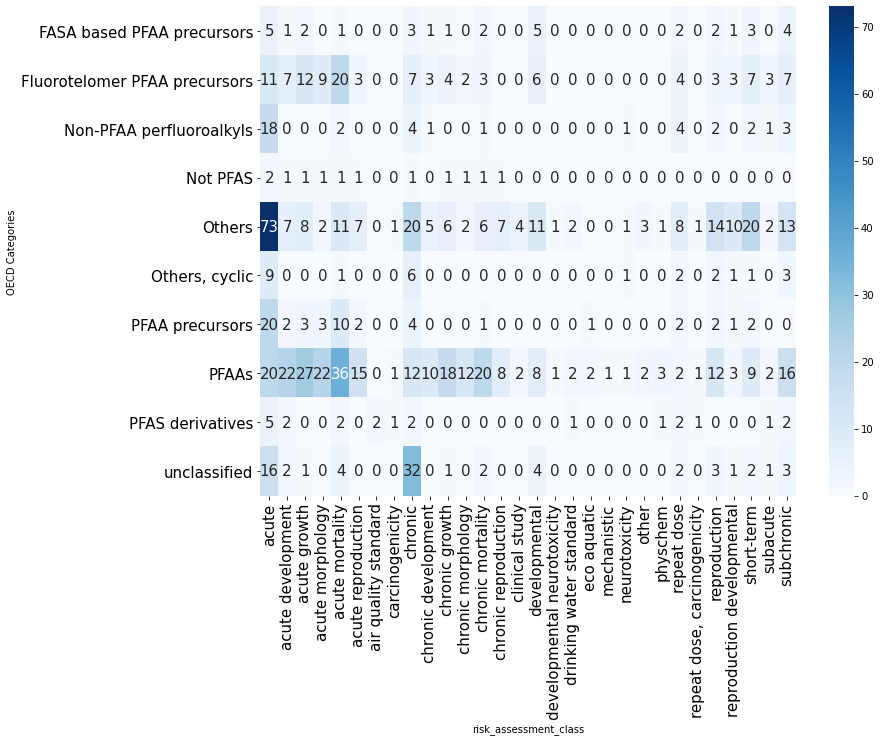

In [162]:
plt.figure(figsize = (12,9))
sns.heatmap(ivdf_pvt.fillna(0).astype(int), annot = True, fmt = 'd', cmap = 'Blues', annot_kws={"size": 15})
plt.xticks(fontsize = 15, rotation = 90)
plt.yticks(fontsize = 15)
plt.savefig(figures_dir+'pfas_iv_unique_171121.png', dpi = 300, bbox_inches='tight');

In [171]:
pfas_iv_wcats.head()

,index,dtxsid,casrn,name,toxval_id,source,subsource,toxval_type,toxval_type_original,toxval_subtype,...,author,journal,volume,year.1,issue,url,document_name,record_source_type,record_source_hash,value
0,2679,DTXSID6021325,116-14-3,Tetrafluoroethylene,227090,ECHA IUCLID,EU REACH,-,other:,-,...,-,-,-,1984,-,-,-,website,-,PFAS derivatives
1,2819,DTXSID10881307,90622-71-2,"Alkyl iodides, C6-18, perfluoro",229592,ECHA IUCLID,EU REACH,-,other:,-,...,-,-,-,1997,-,https://echa.europa.eu/registration-dossier/-/...,-,website,-,unclassified
2,6808,DTXSID40881294,85995-91-1,"Alkyl iodides, C8-14, gamma-mu-perfluoro",292485,ECHA IUCLID,EU REACH,-,other:,-,...,-,-,-,1975,-,https://echa.europa.eu/registration-dossier/-/...,-,website,-,unclassified
3,8615,DTXSID60881291,85631-54-5,Perfluoroalkylethyl acrylates (C6-C14),323368,ECHA IUCLID,EU REACH,-,other:,-,...,-,-,-,2012,-,-,-,website,-,unclassified
4,8616,DTXSID60881291,85631-54-5,Perfluoroalkylethyl acrylates (C6-C14),323371,ECHA IUCLID,EU REACH,-,other:,-,...,-,-,-,2012,-,-,-,website,-,unclassified


In [179]:
nam_ids = pd.read_sql('''select distinct(dtxsid) from ChemList where value = 'PFAS NAM All' ''', pfas_db)['dtxsid'].tolist()

In [183]:
pfas_iv_wcats['tag'] = pfas_iv_wcats.apply(lambda x: 1 if x['dtxsid'] in nam_ids else 0, axis = 1)

In [210]:
pfas_iv_wcats.tag.value_counts()
temp = pfas_iv_wcats.groupby(['value', 'tag']).agg({'dtxsid': [ 'nunique']}).reset_index()


In [222]:
temp[temp[(   'tag',        '')] == 1][('dtxsid', 'nunique')].sum()

62

In [193]:
df2 = pfas_iv_wcats.groupby(['value', 'tag']).agg({'dtxsid': ['count', 'nunique']}).reset_index()

In [194]:
df2 = df2.droplevel(0, axis =1)

In [196]:
df2.head()

,,,count,nunique
0,FASA based PFAA precursors,0,44,4
1,FASA based PFAA precursors,1,592,3
2,Fluorotelomer PFAA precursors,0,309,15
3,Fluorotelomer PFAA precursors,1,2234,13
4,Non-PFAA perfluoroalkyls,0,148,18


In [197]:
df2.columns = ['OECD_Category',  'NAM_tested', 'count', 'nunique_dtxsid']

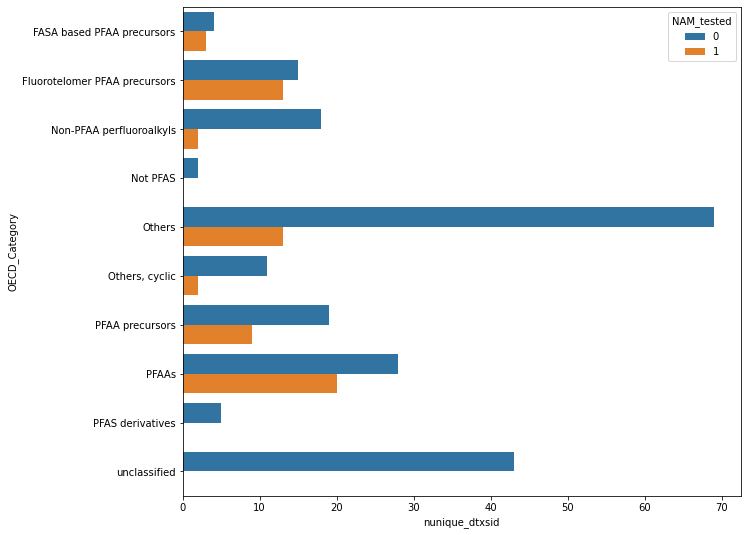

In [202]:
plt.figure(figsize = (10,9))
sns.barplot(y = 'OECD_Category', x = 'nunique_dtxsid', hue = 'NAM_tested', data = df2)
plt.savefig(figures_dir+'pfas_iv_NAMs_171121.png', dpi = 300, bbox_inches='tight');

In [249]:
chunk_size=75000
batch_no=1
for chunk in pd.read_csv(interim_dir+'biodeg_310821_DND.csv', chunksize=chunk_size,iterator=True):
    chunk.to_sql('biodeg6558',pfas_db, if_exists='append')
    batch_no+=1
    print('index: {}'.format(batch_no))

index: 2
index: 3


In [250]:
pd.read_sql('''select count(*) from biodeg6558''', pfas_db)

,count(*)
0,126690


In [254]:
pd.read_sql('''select * from biodeg6558 limit 10''', pfas_db)

,index,Unnamed: 0,#,Cas#,Parent,Smiles,DTXSID,Parent_SMILES,Quantity [mol/mol parent],Clean_SMILES,idx,Parent_id,Revised_SMILES,ID,INCHI_KEY
0,0,0,1.1,678-39-7,Parent,OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...,DTXSID7029904,OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...,0.0,OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...,1.1,DTXSID7029904,OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...,DTXSID7029904,JJUBFBTUBACDHW-UHFFFAOYSA-N
1,1,1,NaN,None,None,O=CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)...,None,None,NaN,O=CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)...,1.1,DTXSID7029904,O=CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)...,DTXSID7029904_m_1,KDGIOTBLYAPNRR-UHFFFAOYSA-N
2,2,2,NaN,None,None,OC(=O)CC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)...,None,None,NaN,OC(=O)CC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)...,1.1,DTXSID7029904,OC(=O)CC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)...,DTXSID7029904_m_2,XTBXSCIWOVSSGB-UHFFFAOYSA-N
3,3,3,NaN,None,None,OC(=O)C=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F...,None,None,NaN,OC(=O)C=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F...,1.1,DTXSID7029904,OC(=O)C=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F...,DTXSID7029904_m_3,WHZXTVOEGZRRJM-UHFFFAOYSA-N
4,4,4,NaN,None,None,C=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...,None,None,NaN,C=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...,1.1,DTXSID7029904,C=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...,DTXSID7029904_m_4,WYSIIRZUWIQJCG-UHFFFAOYSA-N
5,5,5,NaN,None,None,FC1(C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)...,None,None,NaN,FC1(C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)...,1.1,DTXSID7029904,FC1(C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)...,DTXSID7029904_m_5,UZJWPACBOKDHLG-UHFFFAOYSA-N
6,6,6,NaN,None,None,OCC(O)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,None,None,NaN,OCC(O)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,1.1,DTXSID7029904,OCC(O)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,DTXSID7029904_m_6,UCUMCQCIMLHLRZ-UHFFFAOYSA-N
7,7,7,NaN,None,None,OCC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)...,None,None,NaN,OCC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)...,1.1,DTXSID7029904,OCC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)...,DTXSID7029904_m_7,RTAIXCNHUPHCCA-UHFFFAOYSA-N
8,8,8,NaN,None,None,O=CC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,None,None,NaN,O=CC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,1.1,DTXSID7029904,O=CC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,DTXSID7029904_m_8,VJZRADCESIUIRA-UHFFFAOYSA-N
9,9,9,NaN,None,None,OC(=O)C(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)...,None,None,NaN,OC(=O)C(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)...,1.1,DTXSID7029904,OC(=O)C(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)...,DTXSID7029904_m_9,DFPMQRIUBBEEHF-UHFFFAOYSA-N


In [251]:
qc_fails = ['DTXSID70379295' ,'DTXSID30340244',

'DTXSID80881157', 

'DTXSID90558000', 

'DTXSID80371164', 

'DTXSID30378880' ,

'DTXSID00442840' ,

'DTXSID80379781', 

'DTXSID1074915' ,

'DTXSID9059969' ,

'DTXSID00223797', 

'DTXSID00892442', 

'DTXSID70880215'] 

In [255]:
cid = tuple(qc_fails)

In [273]:
myquery = 'select * from biodeg6558 where Parent_id in {}'.format(cid)

In [264]:
pfas_db = sa.create_engine(f"""mysql+pymysql://{username}:{password}@{host}/pfas_db_20211011""")

In [265]:
connection = pfas_db.connect()

In [267]:
stmt = 'select * from biodeg6558 limit 10'

In [272]:
print(myquery)

select * from biodeg6558 where Parent_id is in ('DTXSID70379295', 'DTXSID30340244', 'DTXSID80881157', 'DTXSID90558000', 'DTXSID80371164', 'DTXSID30378880', 'DTXSID00442840', 'DTXSID80379781', 'DTXSID1074915', 'DTXSID9059969', 'DTXSID00223797', 'DTXSID00892442', 'DTXSID70880215')


In [279]:
results = connection.execute(myquery).fetchall()
bio = pd.DataFrame(results, columns = results[0].keys())

In [281]:
bio.Parent_id.nunique()

9

In [282]:
len(cid)

13

In [283]:
biodeg13 = pd.read_csv(external_dir+'biodeg_actives_4Catalogic_results.txt', sep = '\t')

In [297]:
biodeg13 = biodeg13.iloc[:191,:]

In [299]:
biodeg13.head()

,#,Cas#,Chem. Name,Smiles,Quantity [mol/mol parent],log Kow
0,1.1,NaN,DTXSID70379295,OC(O)(C(F)C(O)(O)C(F)(F)F)C(F)(F)F,0.66980,2.0299
1,NaN,NaN,NaN,OC(C(O)(O)C(F)(F)F)C(O)(O)C(F)(F)F,0.07318,1.2188
2,NaN,NaN,NaN,OC(C1(O)C(F)(F)O1)C(O)(O)C(F)(F)F,0.02393,2.2487
3,NaN,NaN,NaN,OC(O)(C(F)C1(O)C(F)(F)O1)C(F)(F)F,0.00000,1.9850
4,NaN,NaN,NaN,OC(O)(C(F)C(O)(O)C(O)(F)F)C(F)(F)F,0.00000,1.2188


In [300]:
def smi_inchi(x):
    mol = Chem.MolFromSmiles(x)
    clean_smi = Chem.MolToSmiles(mol, isomericSmiles=False)
    clean_mol = Chem.MolFromSmiles(clean_smi)
    inchi =     Chem.MolToInchi(clean_mol)
    inchi_key = Chem.InchiToInchiKey(inchi)
    return inchi_key


In [303]:
biodeg13['INCHI_KEY'] = biodeg13['Smiles'].apply(lambda x: smi_inchi(x))

RDKit WARNING: [11:29:41] WARNING: Omitted undefined stereo
RDKit WARNING: [11:29:41] WARNING: Omitted undefined stereo
RDKit WARNING: [11:29:41] WARNING: Omitted undefined stereo
RDKit WARNING: [11:29:41] WARNING: Omitted undefined stereo
RDKit WARNING: [11:29:41] WARNING: Omitted undefined stereo
RDKit WARNING: [11:29:41] WARNING: Omitted undefined stereo
RDKit WARNING: [11:29:41] WARNING: Omitted undefined stereo
RDKit WARNING: [11:29:41] WARNING: Omitted undefined stereo
RDKit WARNING: [11:29:41] WARNING: Omitted undefined stereo
RDKit WARNING: [11:29:41] WARNING: Omitted undefined stereo
RDKit WARNING: [11:29:41] WARNING: Omitted undefined stereo
RDKit WARNING: [11:29:41] WARNING: Omitted undefined stereo
RDKit WARNING: [11:29:41] WARNING: Omitted undefined stereo
RDKit WARNING: [11:29:41] WARNING: Omitted undefined stereo
RDKit WARNING: [11:29:41] WARNING: Omitted undefined stereo
RDKit WARNING: [11:29:41] WARNING: Omitted undefined stereo
RDKit WARNING: [11:29:41] WARNING: Omitt

In [308]:
biodeg13['ID'] = biodeg13['Chem. Name'].fillna(method = 'ffill')

<ipython-input-308-a05ff08e3f4e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  biodeg13['ID'] = biodeg13['Chem. Name'].fillna(method = 'ffill')


In [309]:
biodeg13

,#,Cas#,Chem. Name,Smiles,Quantity [mol/mol parent],log Kow,INCHI_KEY,ID
0,1.1,NaN,DTXSID70379295,OC(O)(C(F)C(O)(O)C(F)(F)F)C(F)(F)F,0.669800,2.0299,NZCXKNVJJQJKKN-UHFFFAOYSA-N,DTXSID70379295
1,NaN,NaN,NaN,OC(C(O)(O)C(F)(F)F)C(O)(O)C(F)(F)F,0.073180,1.2188,KWASZAGURBFEBX-UHFFFAOYSA-N,DTXSID70379295
2,NaN,NaN,NaN,OC(C1(O)C(F)(F)O1)C(O)(O)C(F)(F)F,0.023930,2.2487,PKUYVDRXLLJYJZ-UHFFFAOYSA-N,DTXSID70379295
3,NaN,NaN,NaN,OC(O)(C(F)C1(O)C(F)(F)O1)C(F)(F)F,0.000000,1.9850,WCDQXJYKKNGHBG-UHFFFAOYSA-N,DTXSID70379295
4,NaN,NaN,NaN,OC(O)(C(F)C(O)(O)C(O)(F)F)C(F)(F)F,0.000000,1.2188,VBAAFLYVZRIIHZ-UHFFFAOYSA-N,DTXSID70379295
...,...,...,...,...,...,...,...,...
186,NaN,NaN,NaN,OC(=O)C(F)(C(F)(F)F)OC(F)(F)C(F)(C(F)F)OC(F)(F...,0.000999,5.2442,IWFYPLSREKLSMZ-UHFFFAOYSA-N,DTXSID00892442
187,NaN,NaN,NaN,OC(=O)C(F)(C(F)F)OC(F)(F)C(F)(C(F)(F)F)OC(F)(F...,0.000999,5.2442,CEHMKIYGTJDZJL-UHFFFAOYSA-N,DTXSID00892442
188,13.1,13252-13-6,DTXSID70880215,OC(=O)C(F)(C(F)(F)F)OC(F)(F)C(F)(F)C(F)(F)F,0.998000,3.6603,CSEBNABAWMZWIF-UHFFFAOYSA-N,DTXSID70880215
189,NaN,NaN,NaN,OC(=O)C(F)(C(F)(F)F)OC(F)(F)C(F)(F)C(F)F,0.000999,3.0525,DFDMCSWFKCBXFL-UHFFFAOYSA-N,DTXSID70880215


In [310]:
biodeg13_dict = {}
for k,v in biodeg13.groupby('ID'):
    k = [e for e in v['ID']][0]
    v = list(v['Smiles'])
    biodeg13_dict[k] = v

In [313]:
biodeg13_dict_smi = {k:[Chem.MolFromSmiles(e) for e in v] for k,v in biodeg13_dict.items()}

In [337]:
list(biodeg13_dict_smi.keys())[6]

'DTXSID70379295'

In [338]:
biodeg13[biodeg13['ID'] == list(biodeg13_dict_smi.keys())[6]]

,#,Cas#,Chem. Name,Smiles,Quantity [mol/mol parent],log Kow,INCHI_KEY,ID
0,1.1,NaN,DTXSID70379295,OC(O)(C(F)C(O)(O)C(F)(F)F)C(F)(F)F,0.66980,2.0299,NZCXKNVJJQJKKN-UHFFFAOYSA-N,DTXSID70379295
1,NaN,NaN,NaN,OC(C(O)(O)C(F)(F)F)C(O)(O)C(F)(F)F,0.07318,1.2188,KWASZAGURBFEBX-UHFFFAOYSA-N,DTXSID70379295
2,NaN,NaN,NaN,OC(C1(O)C(F)(F)O1)C(O)(O)C(F)(F)F,0.02393,2.2487,PKUYVDRXLLJYJZ-UHFFFAOYSA-N,DTXSID70379295
3,NaN,NaN,NaN,OC(O)(C(F)C1(O)C(F)(F)O1)C(F)(F)F,0.00000,1.9850,WCDQXJYKKNGHBG-UHFFFAOYSA-N,DTXSID70379295
4,NaN,NaN,NaN,OC(O)(C(F)C(O)(O)C(O)(F)F)C(F)(F)F,0.00000,1.2188,VBAAFLYVZRIIHZ-UHFFFAOYSA-N,DTXSID70379295
5,NaN,NaN,NaN,OC(O)(C(F)C(=O)C(O)(F)F)C(F)(F)F,0.00000,-0.0715,FIGHPAOPCBJDNI-UHFFFAOYSA-N,DTXSID70379295
6,NaN,NaN,NaN,OC(O)(C(F)C(=O)C(=O)F)C(F)(F)F,0.00000,-1.6513,YEKYBIVBAIAQRW-UHFFFAOYSA-N,DTXSID70379295
7,NaN,NaN,NaN,OC(=O)C(=O)C(F)C(O)(O)C(F)(F)F,0.19300,-1.0077,SCSUJKYJINRJFB-UHFFFAOYSA-N,DTXSID70379295
8,NaN,NaN,NaN,OC(=O)C(=O)C(F)C1(O)C(F)(F)O1,0.03004,-1.4590,SFFLOULPHUZEAQ-UHFFFAOYSA-N,DTXSID70379295
9,NaN,NaN,NaN,OC(=O)C(=O)C1C(O)(C(F)(F)F)O1,0.01001,-0.3090,ONLGXNZXDWOKGX-UHFFFAOYSA-N,DTXSID70379295


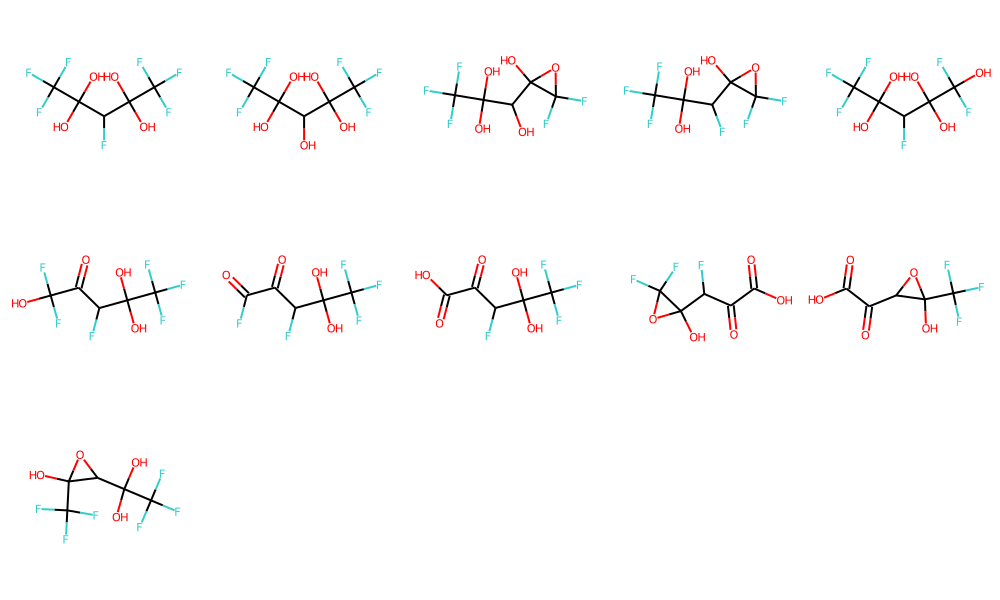

In [339]:
MolsToGridImage(biodeg13_dict_smi[list(biodeg13_dict_smi.keys())[6]], molsPerRow = 5)

In [322]:
pfas_db.table_names()

['Categories',
 'ChemList',
 'HTPP_Cats',
 'HTPP_Chem',
 'HTPP_Cytotox',
 'HTPP_feature',
 'HTS',
 'HTTR_signature',
 'HTTR_signature_active',
 'HTTR_supertarget',
 'PFAS_Landscape',
 'QC',
 'QC_summary',
 'biodeg6558',
 'invivo',
 'physchem']

In [ ]:
pd.read_sql('''select''')

In [323]:
my_ivt = 'select * from HTS where dtxsid in {}'.format(cid)
results2 = connection.execute(my_ivt).fetchall()
ivt = pd.DataFrame(results2, columns = results2[0].keys())

In [325]:
ivt['hitc'] = ivt['hitcall'].apply(lambda x: 1 if x==1 else 0)

<AxesSubplot:xlabel='hts_assay_name', ylabel='dtxsid'>

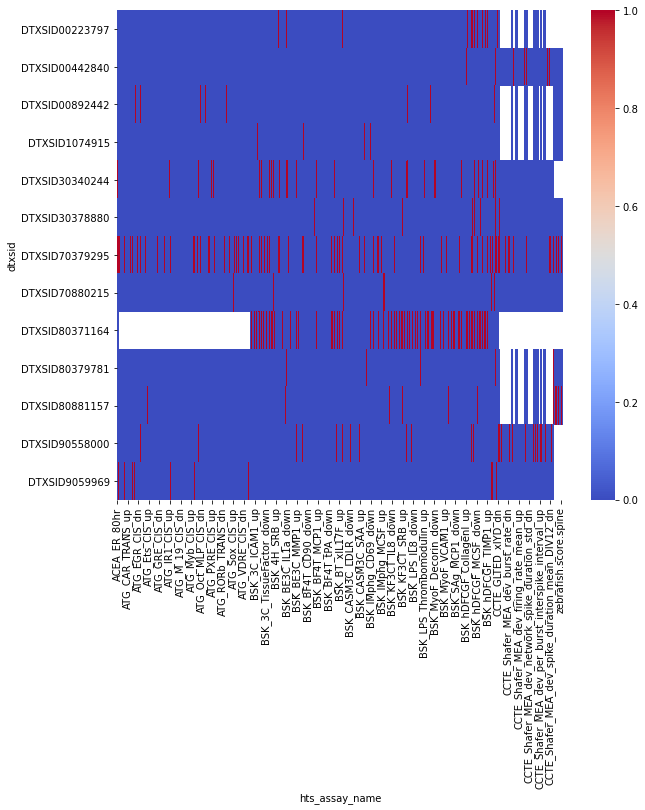

In [332]:
plt.figure(figsize = (10,9))
sns.heatmap(ivt.pivot_table(index = 'dtxsid', columns = 'hts_assay_name', aggfunc = 'max', values = 'hitc'), cmap = 'coolwarm')

In [342]:
ivt_pvt = ivt.pivot_table(index = 'dtxsid', columns = 'hts_assay_name', aggfunc = 'max', values = 'hitc')



In [360]:
temp = ivt_pvt.loc['DTXSID70379295'].where(lambda x : x==1).dropna().reset_index().T

In [361]:
temp.columns = temp.iloc[0]
temp = temp[1:]

In [375]:
temp

hts_assay_name,ACEA_ER_AUC_viability,ATG_AP_1_CIS_dn,ATG_AP_2_CIS_dn,ATG_BRE_CIS_dn,ATG_CMV_CIS_dn,ATG_CRE_CIS_up,ATG_C_EBP_CIS_up,ATG_DR4_LXR_CIS_dn,ATG_EGR_CIS_dn,ATG_ERE_CIS_up,...,CCTE_Shafer_MEA_dev_correlation_coefficient_mean_up,CCTE_Shafer_MEA_dev_inter_network_spike_interval_mean_DIV12_up,CCTE_Shafer_MEA_dev_mutual_information_norm_up,CCTE_Shafer_MEA_dev_per_network_spike_spike_percent_up,CCTE_Shafer_MEA_dev_spike_duration_mean_DIV12_up,zebrafish.score.any,zebrafish.score.blood_pooling,zebrafish.score.general,zebrafish.score.living,zebrafish.score.swim_bladder
DTXSID70379295,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [378]:
temp = ivt_pvt.loc['DTXSID70379295'].where(lambda x : x==1).dropna().reset_index()

In [391]:
temp[temp['hts_assay_name'].str.contains('ATG')]

,hts_assay_name,DTXSID70379295
1,ATG_AP_1_CIS_dn,1.0
2,ATG_AP_2_CIS_dn,1.0
3,ATG_BRE_CIS_dn,1.0
4,ATG_CMV_CIS_dn,1.0
5,ATG_CRE_CIS_up,1.0
6,ATG_C_EBP_CIS_up,1.0
7,ATG_DR4_LXR_CIS_dn,1.0
8,ATG_EGR_CIS_dn,1.0
9,ATG_ERE_CIS_up,1.0
10,ATG_ERa_TRANS_up,1.0


In [433]:
atg_all = pd.read_sql('''select c.value, h.dtxsid, h.hts_assay_name, h.source, h.hitcall from HTS as h left join Categories as c on h.dtxsid=c.dtxsid where h.source = 'ATG'  ''', pfas_db)

In [434]:
atg_pvt = pd.pivot_table(index = ['value','dtxsid'], values = 'hitcall', columns = 'hts_assay_name', aggfunc = 'max', data = atg_all)

<AxesSubplot:xlabel='hts_assay_name', ylabel='dtxsid'>

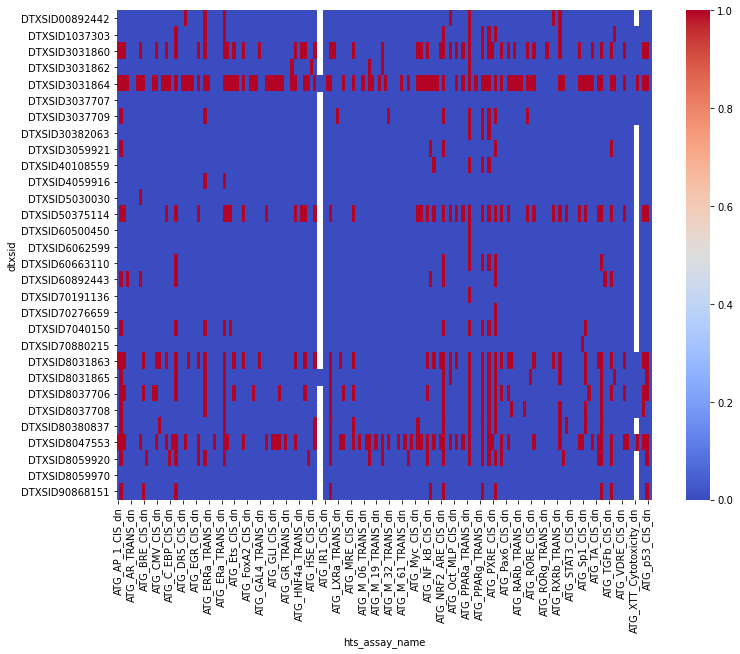

In [443]:
plt.figure(figsize = (12,9))
sns.heatmap(atg_pvt.loc[('PFAAs')], cmap = 'coolwarm')

In [447]:
pd.read_sql('''select * from HTS where dtxsid in ('DTXSID3031864','DTXSID3031860') ''', pfas_db)

,index,dtxsid,casrn,name,spid,hts_assay_name,source,gene_symbol,hitcall,pod,pod_type,top,sample_qc,flag
0,15,DTXSID3031864,1763-23-1,Perfluorooctanesulfonic acid,TP0001412H11,CCTE_Shafer_MEA_acute_per_network_burst_electr...,CCTE_SHAFER,-,0.0,1000.000000,AC50,0.00000,ND,-
1,26,DTXSID3031864,1763-23-1,Perfluorooctanesulfonic acid,TP0001412H11,CCTE_Shafer_MEA_acute_network_burst_percentage_dn,CCTE_SHAFER,-,0.0,1000.000000,AC50,0.00000,ND,-
2,34,DTXSID3031864,1763-23-1,Perfluorooctanesulfonic acid,TP0001412H11,CCTE_Shafer_MEA_acute_network_burst_percentage_up,CCTE_SHAFER,-,0.0,1000.000000,AC50,0.00000,ND,-
3,40,DTXSID3031860,335-76-2,Perfluorodecanoic acid,TP0000422B05,ATG_RORE_CIS_up,ATG,RORA,1.0,28.627934,AC50,1.34443,P,Z
4,46,DTXSID3031864,1763-23-1,Perfluorooctanesulfonic acid,TP0000133H06,ATG_RORE_CIS_up,ATG,RORA,0.0,1000.000000,AC50,0.00000,P,"Z, I"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4378,165592,DTXSID3031864,1763-23-1,Perfluorooctanesulfonic acid,1485986,zebrafish.score.blood_pooling,Padilla lab,-,0.0,1000.000000,bmd,0.00000,P,"Z, I"
4379,165593,DTXSID3031864,1763-23-1,Perfluorooctanesulfonic acid,1504164,zebrafish.score.blood_pooling,Padilla lab,-,0.0,1000.000000,bmd,0.00000,P,"Z, I"
4380,165728,DTXSID3031860,335-76-2,Perfluorodecanoic acid,1504214,zebrafish.score.any,Padilla lab,-,1.0,17.668920,bmd,1.00000,P,Z
4381,165748,DTXSID3031864,1763-23-1,Perfluorooctanesulfonic acid,1485986,zebrafish.score.any,Padilla lab,-,1.0,8.270923,bmd,1.00000,P,"Z, I"
